<a href="https://colab.research.google.com/github/isaac-yong0804/RojakML/blob/master/Comma10k.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!git clone https://github.com/commaai/comma10k.git

Cloning into 'comma10k'...
remote: Enumerating objects: 64112, done.
remote: Counting objects: 100% (2372/2372), done.
remote: Compressing objects: 100% (2198/2198), done.
remote: Total 64112 (delta 244), reused 2210 (delta 174), pack-reused 61740
Receiving objects: 100% (64112/64112), 7.48 GiB | 37.35 MiB/s, done.
Resolving deltas: 100% (8381/8381), done.
Checking out files: 100% (20600/20600), done.


# Import Libraries and Some Hyperparameters

In [1]:
import torch
import torch.nn.functional as F
import torch.optim as optimizer
import torchvision
import numpy as np
import matplotlib.pyplot as plt
import cv2
import copy
from google.colab.patches import cv2_imshow
import time

In [2]:
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')
dtype = torch.float
images_path = "comma10k/imgs/"
masks_path = "comma10k/masks/"
data_path = "comma10k/files_trainable" 
saved_model_path = "model_comma_10k.pt"
saved_checkpoint_path = None # "checkpoint_comma_10k.pt"
num_workers = 2
epochs = 100
begin_epoch = 0
batch_size = 8
learning_rate = 1e-3
print(device)

cuda


# Data Input Pipeline

In [3]:
class DataRetriever(torch.utils.data.Dataset):
  def __init__(self, is_train_data=True):
    self.class_values = [41, 76, 90, 124, 161, 0]
    self.is_train_data = is_train_data
    self.filenames = []

    with open(data_path, 'r') as f:
      lines = f.readlines()
    
    if self.is_train_data:
      self.filenames = [x.split('masks/')[-1].replace('\n', '') for x in lines if not x.endswith('9.png\n')]
      # self.filenames = self.filenames[:2000]
    else:
      self.filenames = [x.split('masks/')[-1].replace('\n', '') for x in lines if x.endswith('9.png\n')]
      # self.filenames = self.filenames[:200]
    
    if not self.filenames:
      print("Data is not loaded")
    else:
      print(f"Data of size {len(self)} is loaded")
  
  def __len__(self):
    return len(self.filenames)
  
  def __getitem__(self, idx):
    image = cv2.imread(images_path+self.filenames[idx])
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)/255
    image = image.transpose((2, 0, 1))

    mask = cv2.imread(masks_path+self.filenames[idx], 0).astype('uint8')
    mask = np.stack([mask == v for v in self.class_values], axis=-1).astype('uint8') 
    mask = mask.transpose((2, 0, 1))

    return torch.tensor(image, dtype=dtype), torch.tensor(mask, dtype=dtype)

In [4]:
train_dataset = DataRetriever(is_train_data=True)
valid_dataset = DataRetriever(is_train_data=False)

train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=num_workers)
valid_loader = torch.utils.data.DataLoader(valid_dataset, batch_size=batch_size, shuffle=True, num_workers=num_workers)

Data of size 8908 is loaded
Data of size 976 is loaded


In [5]:
def get_colormap():
  f32 = lambda x: (x % 256, x//256 % 256, x//(256*256) % 256)
  key = [2105408, 255, 16711884, 0x608080, 6749952, 0]
  # road, landline, my car, undrivable, other cars, pad
  return {i: f32(key[i]) for i in range(len(key))}

def gray_to_color(image):
  W,H = image.shape[0:2]
  colormap = get_colormap()
  c = image.ravel()
  output = np.asarray([colormap[i] for i in c]) 
  output = output.reshape((W, H, 3)).astype(np.uint8)
  return output

def display_color(x):
  r = np.full((100, 100), (x % 256))
  g = np.full((100, 100), (x//256 % 256))
  b = np.full((100, 100), (x//(256*256) % 256))
  c = np.stack([r, g, b], axis=-1).astype('uint8')

  c = cv2.cvtColor(c, cv2.COLOR_BGR2RGB)
  cv2_imshow(c) 

In [6]:
dataiter = iter(train_loader)
images, masks = dataiter.next()

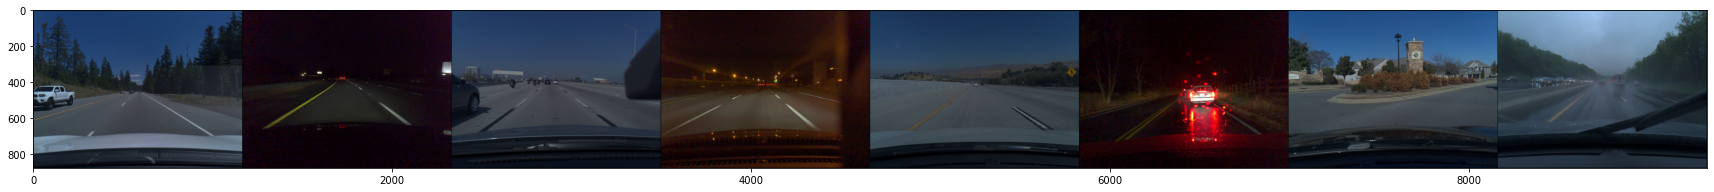

In [7]:
plt.figure(figsize=(30, 20))
plt.imshow(torchvision.utils.make_grid(images).permute((1, 2, 0)));

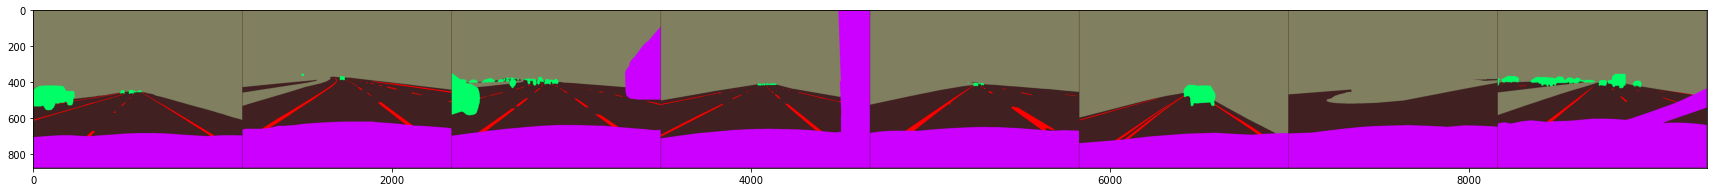

In [8]:
show_masks = torchvision.utils.make_grid(masks)
show_masks = torch.squeeze(torch.argmax(show_masks, dim=0)).numpy()
show_masks = gray_to_color(show_masks)

plt.figure(figsize=(30, 20))
plt.imshow(show_masks);

# Build Model

In [9]:
class Down(torch.nn.Module):
  def __init__(self, in_channels, out_channels, kernel_size=3):
    super().__init__()
    self.conv1 = torch.nn.Conv2d(in_channels, out_channels, kernel_size)
    self.conv2 = torch.nn.Conv2d(out_channels, out_channels, kernel_size, padding='same')
    self.pool = torch.nn.MaxPool2d(2, 2, ceil_mode=True)
    self.batchnorm = torch.nn.BatchNorm2d(out_channels)
  
  def forward(self, x):
    x = self.conv1(x)
    x = self.batchnorm(x)
    x = torch.tanh(x)
    x = self.conv2(x)
    x = self.pool(x)
    x = self.batchnorm(x)
    x = torch.tanh(x)
    return x
  
class Up(torch.nn.Module):
  def __init__(self, in_channels, out_channels, kernel_size=3, paddings=None):
    super().__init__()
    self.conv1 = torch.nn.Conv2d(in_channels, out_channels, kernel_size, padding='same')
    self.conv2 = torch.nn.Conv2d(out_channels, out_channels, kernel_size, padding='same')
    self.up = torch.nn.Upsample(scale_factor=2, mode='bilinear')
    self.batchnorm = torch.nn.BatchNorm2d(out_channels)
    self.pad = torch.nn.ReplicationPad2d(paddings) if paddings is not None else None

  def forward(self, x, skip_x):
    x = self.up(x)
    x = self.pad(x) if self.pad else x
    x = torch.cat((x, skip_x), 1)
    x = self.conv1(x)
    x = self.batchnorm(x)
    x = torch.tanh(x)
    x = self.conv2(x)
    x = self.batchnorm(x)
    x = torch.tanh(x)
    return x

class Model(torch.nn.Module):
  def __init__(self):
    super().__init__()
    self.down1 = Down(3, 16, 5)
    self.down2 = Down(16, 32, 3)
    self.down3 = Down(32, 64, 3)
    self.down4 = Down(64, 128, 3)
    self.down5 = Down(128, 256, 3)
    self.up1 = Up(256+128, 128, 3, paddings=(0, 1, 0, 1))
    self.up2 = Up(128+64, 64, 3, paddings=(1, 1, 1, 1))
    self.up3 = Up(64+32, 32, 3, paddings=(0, 1, 0, 1))
    self.up4 = Up(32+16, 16, 3, paddings=(1, 1, 0, 1))
    self.up5 = Up(16+3, 6, 3, paddings=(2, 2, 2, 2))
    self.dropout = torch.nn.Dropout2d(p=0.1)

  def forward(self, x):
    x_1 = self.down1(x)
    x_2 = self.down2(x_1)
    x_3 = self.down3(x_2)
    x = self.dropout(x)
    x_4 = self.down4(x_3)
    x_5 = self.down5(x_4)
    x = self.dropout(x)

    x_5 = self.up1(x_5, x_4)
    x_5 = self.up2(x_5, x_3)
    x = self.dropout(x)
    x_5 = self.up3(x_5, x_2)
    x_5 = self.up4(x_5, x_1)
    x = self.dropout(x)
    x_5 = self.up5(x_5, x)
    x_5 = F.softmax(x_5, dim=1)

    return x_5

In [10]:
model = Model()
opt = optimizer.Adam(model.parameters(), lr=learning_rate)
criterion = torch.nn.CrossEntropyLoss()

if saved_checkpoint_path is not None:
  checkpoint = torch.load(saved_checkpoint_path)
  model.load_state_dict(checkpoint['model_state_dict'])
  opt.load_state_dict(checkpoint['optimizer_state_dict'])
  begin_epoch = checkpoint['epoch']
  # loss = checkpoint['loss']
elif saved_model_path is not None:
  model.load_state_dict(torch.load(saved_model_path))
model = model.to(device)
model

Model(
  (down1): Down(
    (conv1): Conv2d(3, 16, kernel_size=(5, 5), stride=(1, 1))
    (conv2): Conv2d(16, 16, kernel_size=(5, 5), stride=(1, 1), padding=same)
    (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=True)
    (batchnorm): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  )
  (down2): Down(
    (conv1): Conv2d(16, 32, kernel_size=(3, 3), stride=(1, 1))
    (conv2): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=same)
    (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=True)
    (batchnorm): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  )
  (down3): Down(
    (conv1): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1))
    (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=same)
    (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=True)
    (batchnorm): BatchNorm2d(64, eps=1e-05, momentum=0.1, affin

In [11]:
def cal_acc(output, masks):
  true_labels = (torch.argmax(output, dim=1) == torch.argmax(masks, dim=1)).numpy().astype('uint8')
  accuracy = true_labels.sum() / (batch_size*874*1164)
  return accuracy

In [ ]:
train_accuracies, train_losses = [], []
valid_accuracies, valid_losses = [], []

for epoch in range(begin_epoch+1, begin_epoch+epochs+1):
  start = time.time()
  train_steps, train_acc, train_loss = 0.0, 0.0, 0.0
  valid_steps, valid_acc, valid_loss= 0.0, 0.0, 0.0
  model.train()
  for i, data in enumerate(train_loader, 0):
    images, masks = data
    images, masks = images.to(device), masks.to(device)

    opt.zero_grad()
    predictions = model(images)
    loss = criterion(predictions, torch.argmax(masks, dim=1))
    loss.backward()
    opt.step()
    train_steps += 1.0
    train_acc += cal_acc(predictions.cpu(), masks.cpu())
    train_loss += loss.item()
    del images
    del masks
    break
  
  model.eval()
  with torch.no_grad():
    for i, data in enumerate(valid_loader, 0):
      images, masks = data
      images, masks = images.to(device), masks.to(device)

      predictions = model(images)
      loss = criterion(predictions, torch.argmax(masks, dim=1))
      accuracy = cal_acc(predictions.cpu(), masks.cpu())
      valid_steps += 1.0
      valid_acc += cal_acc(predictions.cpu(), masks.cpu())
      valid_loss += loss.item()
      del images
      del masks
      break
  
  train_acc /= train_steps
  train_loss /= train_steps
  valid_acc /= valid_steps
  valid_loss /= valid_steps

  train_accuracies.append(train_acc)
  train_losses.append(train_loss)
  valid_accuracies.append(valid_acc)
  valid_losses.append(valid_loss)

  print(f"Saving checkpoint of epoch {epoch}")
  torch.save({
            'epoch': epoch,
            'model_state_dict': model.state_dict(),
            'optimizer_state_dict': opt.state_dict(),
            'loss': train_loss
            }, f'checkpoint_comma_10k_{epoch}e.pt')
  print(f"Saving model of epoch {epoch}")
  torch.save(copy.deepcopy(model.state_dict()), f'model_comma_10k_{epoch}e.pt')

  print(f"Epoch: {epoch}, Time Taken: {time.time() - start}s")
  print(f"Train Accuracy: {train_acc}, Train Loss: {train_loss}")
  print(f"Valid Accuracy: {valid_acc}, Valid Loss: {valid_loss}")